In [71]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from math import log
import csv
import string 
import matplotlib.pyplot as plt



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Correlation between the weighted price index and PILANIINVS.NS: 0.96


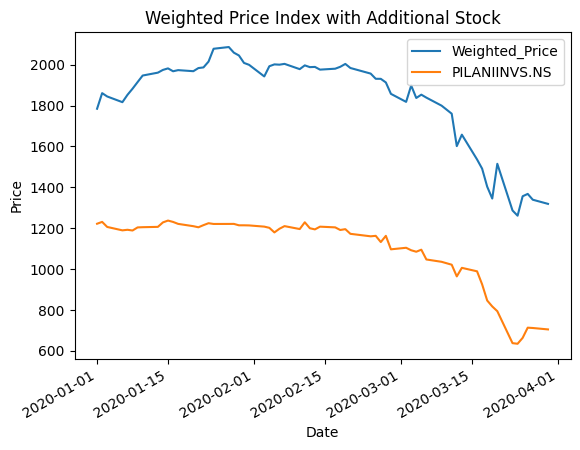

[*********************100%%**********************]  1 of 1 completed


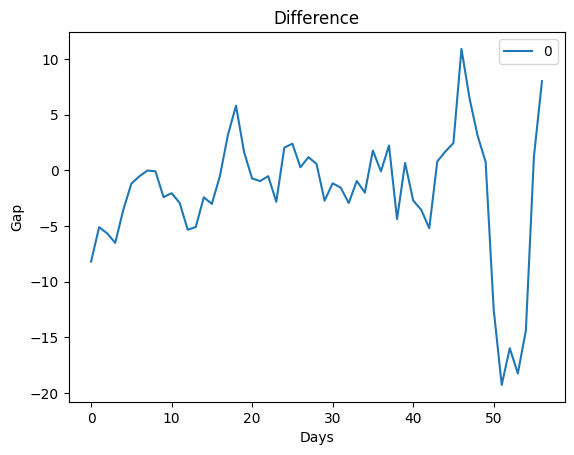

Profit:  -2153.899550691017
Returns:  -44.73547077720189
    Position        Price
0        Buy  1840.448426
1   Buy Main  1048.000445
2       Sell  1655.786876
3  Sell Main  1005.060157
4        Buy  1287.955540
5   Buy Main   638.342172
Mean:  -1.9266260113839995 Variance:  5.613336734087219


In [72]:
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Adj Close']

#Calculates price action of the stocks in holding according to their weights.
def calculate_weighted_price(stock_data_dict, weights):
    return sum(stock_data * weight for stock_data, weight in zip(stock_data_dict.values(), weights))

def plot_weighted_price_and_correlation(stock_data_dict, weights, additional_stock_data, additional_stock_label):
    # Calculate the weighted price
    weighted_price = calculate_weighted_price(stock_data_dict, weights)
    
    # Create a DataFrame with both series
    df = pd.DataFrame({'Weighted_Price': weighted_price, additional_stock_label: additional_stock_data})

    # Calculate correlation using Pandas
    correlation = df.corr().loc['Weighted_Price', additional_stock_label]
    print(f'Correlation between the weighted price index and {additional_stock_label}: {correlation:.2f}')

    # Plot the data
    df.plot()
    plt.title('Weighted Price Index with Additional Stock')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

#Calculates the gap in returns of the weighted holding stocks and the main holding company's returns. Then stores them into list.
def plot_return_gap(stock_data_dict, additional_stock_label, weights, start_date, end_date):
    holding_returns = log_returns(stock_data_dict, weights, 1, start_date, end_date)
    main_company_returns = log_returns(additional_stock_label, weights, 0, start_date, end_date)
    list = []
    for i in range(len(holding_returns)):
        if str(holding_returns[i]-main_company_returns[i]) != 'nan':
            list.append(main_company_returns[i]-holding_returns[i])
        else: continue
    
    # Plot the weighted price index with the additional stock and calculate correlation
    data = pd.DataFrame(list)
    data.plot()
    plt.title('Difference')
    plt.xlabel('Days')
    plt.ylabel('Gap')
    plt.legend()
    plt.show()
    return list

#Calculate returns in a n day window. n=5
def log_returns(stock_data_dict, weights, isIndex, start_date, end_date):
    log_price = []
    if isIndex == 1:
        price_data = list(calculate_weighted_price(stock_data_dict, weights).values)
    else:
        price_data = list(yf.download(stock_data_dict, start=start_date, end=end_date)['Adj Close'].values)
    for i in range(5, len(price_data)):
        log_price.append(((price_data[i]/price_data[i-5])-1)*100)
    return log_price

# Creates a Trade Log
def trade_book():
    tradelog = pd.DataFrame(columns = ['Position', 'Price'])
    return tradelog

#Defines entry and exit.
def entry_exit(list, main_company_price_data, holding_price_data):
    tradebook = trade_book()
    max=0
    for i in range(len(list)):
        if max == 0:
            if list[i]>np.std(list)+2:
                max = 1
                tradebook.loc[len(tradebook)] = ["Buy", holding_price_data[i]*1.001]
                tradebook.loc[len(tradebook)] = ["Buy Main", main_company_price_data[i]*1.001]
        if max == 1 :
            if list[i]<0.42:
                tradebook.loc[len(tradebook)] = ["Sell", holding_price_data[i]*0.999]
                tradebook.loc[len(tradebook)] = ["Sell Main", main_company_price_data[i]*0.999]
                max = 0
    return tradebook     

#Calculates PnL
def pnl(tradebook, list, main_company_price_data, holding_price_data):
    tradebook = entry_exit(list, main_company_price_data, holding_price_data)
    buying = tradebook.loc[tradebook['Position'] == 'Buy']['Price'].sum() + tradebook.loc[tradebook['Position'] == 'Buy Main']['Price'].sum()
    selling = tradebook.loc[tradebook['Position'] == 'Sell']['Price'].sum() + tradebook.loc[tradebook['Position'] == 'Sell Main']['Price'].sum()
    print('Profit: ', selling-buying )
    print('Returns: ', (selling/buying-1)*100)
    
def main():
    # Define the stocks and their weights
    stocks = ['ABREL.NS', 'KESORAMIND.NS', 'MANGLMCEM.BO', 'ULTRACEMCO.BO', 'ABFRL.NS','IDEA.NS','PILANIINVS.NS']
    weights = [0.482, 0.087, 0.012, 0.391,0.010, 0.019]  # You can customize the weights as per your preference

    # User input for date range
    start_date = '2020-01-01'
    end_date = '2020-03-31'

    # Fetch stock data
    stock_data_dict = {ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in stocks[:-1]}  # Exclude the last stock
    additional_stock_data = fetch_stock_data(stocks[-1], start_date, end_date)
    additional_stock_label = stocks[-1]
    
    holding_price_data = np.array(calculate_weighted_price(stock_data_dict, weights).values)
    main_company_price_data = np.array(fetch_stock_data(additional_stock_label, 
                                                        start_date, end_date))
    
    plot_weighted_price_and_correlation(stock_data_dict, weights, 
                                        additional_stock_data, 
                                        additional_stock_label)
    
    list= np.array(plot_return_gap(stock_data_dict, 
                                   additional_stock_label, weights, 
                                   start_date, end_date))
    
    tradebook = entry_exit(list, main_company_price_data, holding_price_data)
    pnl(tradebook, list, main_company_price_data, holding_price_data)
    print(tradebook)
    print("Mean: ", np.mean(list), "Variance: ", np.std(list))
if __name__ == "__main__":
    main()


## 